In [1]:
from bg_atlasapi import BrainGlobeAtlas
from preprocessing_sequencing import preprocess_sequences as ps
from znamutils import slurm_it
import pandas as pd
from final_processing import final_processing_functions as fpf
import numpy as np
import nrrd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern
import pathlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
from sklearn.preprocessing import normalize
import ast
import seaborn as sb
import pickle
import warnings
from scipy import stats
from matplotlib.patches import Rectangle
import scipy
from scipy.stats import binomtest
warnings.filterwarnings('ignore')
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import itertools
%matplotlib inline

In [2]:
def get_cond_prob(matrix, columns, index):
    """ function to get the conditional probability a neuron projects to an area (column) given it projects to another area (index)"""
    conditional_prob = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns= columns, index=index)
    matrix = matrix[columns]
    for col in index:
        for area in columns:
            if col == area:
                conditional_prob.loc[col, area] = np.nan
            else:
                conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
    return conditional_prob

In [3]:
mice = ['FIAA45.6a', 'FIAA45.6d', 'FIAA55.4d']
mcc = MouseConnectivityCache()
structure_tree = mcc.get_structure_tree()
combined_dict = {}
for num, mouse in enumerate(mice):
    new_dict = {}
    parameters_path = (
    f"/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/{mouse}/Sequencing")
    barcodes = pd.read_pickle(f"{parameters_path}/A1_barcodes_thresholded.pkl")
    new_dict['homogenous_across_cubelet'] = fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, dummy_data=False, IT_only=True, area_threshold=0.1)
    new_dict['homogenous_across_area'] = fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=False, IT_only=True)
    new_dict['area_is_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=False, shuffled=False,  IT_only=True)
    new_dict['shuff_cubelet']= fpf.homog_across_cubelet(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, dummy_data=False, IT_only=True)
    new_dict['shuff_area']=fpf.homog_across_area(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True, IT_only=True)
    new_dict['shuff_main'] = fpf.area_is_main(parameters_path=parameters_path, barcode_matrix = barcodes, cortical=True, shuffled=True,  IT_only=True)
    combined_dict[mouse] = new_dict
analysis_names =['homogenous_across_cubelet', 'homogenous_across_area', 'area_is_main', 'shuff_cubelet', 'shuff_area', 'shuff_main']
all_combined = {}
for i, key in enumerate(analysis_names):
    #common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(combined_dict['FIAA45.6d'][key].columns)
    common_columns = set(combined_dict['FIAA45.6a'][key].columns).intersection(
    set(combined_dict['FIAA45.6d'][key].columns)
).intersection(
    set(combined_dict['FIAA55.4d'][key].columns)
)
    common_cols_cortex = []
    for col in common_columns:
        if col not in ['Contra', 'OB']:
            structure = structure_tree.get_structures_by_acronym([col])
            if 315 in structure[0]['structure_id_path']:
                common_cols_cortex.append(col)
    combined_matrix = pd.concat([combined_dict['FIAA45.6a'][key][common_cols_cortex], combined_dict['FIAA45.6d'][key][common_cols_cortex], combined_dict['FIAA55.4d'][key][common_cols_cortex]])
    cols = ['VISal', 'VISl',  'VISli','VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
    #cols = ['VISli','VISpor', 'VISpl', 'VISl', 'VISp', 'VISal', 'VISam', 'VISpm', 'VISa', 'VISrl']
    all_combined[key] = combined_matrix

In [4]:
def get_cond_prob(matrix, columns, index):
    """ function to get the conditional probability a neuron projects to an area (column) given it projects to another area (index)"""
    conditional_prob = pd.DataFrame(data=np.zeros((len(index), len(columns))), columns= columns, index=index)
    matrix = matrix[columns]
    for col in index:
        for area in columns:
            if col == area:
                conditional_prob.loc[col, area] = np.nan
            else:
                conditional_prob.loc[col, area] = matrix[matrix[col]>0].astype(bool).astype(int)[area].mean()
    return conditional_prob

In [14]:
#let's first calculate the mean conditional probability across mice
key='homogenous_across_cubelet'
which = 'cubelet'
shuff = f'shuff_{which}'
common_cols = all_combined[key].columns
cols = ['VISal', 'VISl', 'VISli', 'VISpor', 'VISpl', 'VISp', 'VISam', 'VISa', 'VISpm', 'VISrl']
cols = [col for col in cols if col in common_cols]
cols_reordered = [item for item in cols if item in common_cols] + [item for item in common_cols if item not in cols]
cols_reordered = [item for item in cols_reordered if item != 'AUDp']
cond_prob_dict = {}
shuff_cond_prob_dict = {}
mouse_cond_prob_minus_shuff = {}
for mouse in mice:
    cond_prob_dict[mouse]= get_cond_prob(matrix = combined_dict[mouse][key], columns = cols_reordered, index = cols_reordered)
    shuff_cond_prob_dict[mouse] = get_cond_prob(matrix = combined_dict[mouse][shuff], columns = cols_reordered, index = cols_reordered)
    shuffled_cond_prob = pd.read_pickle(f'/camp/lab/znamenskiyp/home/shared/projects/turnerb_A1_MAPseq/collated_shuffles/shuffled_{which}_conditional_prob_{mouse}_collated.pkl')
    mean_val_matrix = pd.DataFrame(data=np.zeros((len(cols_reordered), len(cols_reordered))), columns= cols_reordered, index=cols_reordered)
    for column_name in shuffled_cond_prob.columns:
        separated_words = column_name.split(', ')
        mean_corr = shuffled_cond_prob[column_name].mean()
        if separated_words[0] in cols_reordered and separated_words[1] in cols_reordered:
                mean_val_matrix.loc[separated_words[0], separated_words[1]] = mean_corr
    #shuff_cond_prob_dict[mouse] = mean_val_matrix
    mouse_cond_prob_minus_shuff[mouse] = cond_prob_dict[mouse]-mean_val_matrix
#now let's calculate the  shuffled conditional probability across mice



#for each mouse, let's now minus the conditional probability from mean shuffled, and make a mean of that



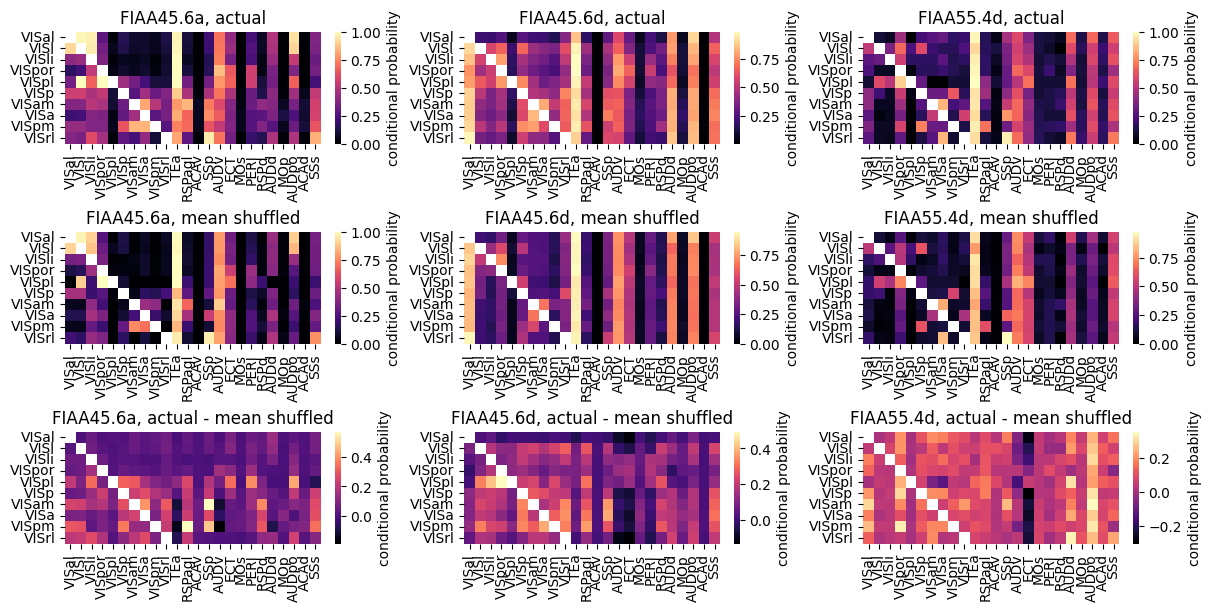

In [15]:
titles = ['actual', 'mean shuffled', 'actual - mean shuffled']
fig, axs = plt.subplots(3, 3, figsize=(12, 6), constrained_layout = True)
for which_numb, dict_to_look in enumerate([cond_prob_dict, shuff_cond_prob_dict, mouse_cond_prob_minus_shuff]):
    for i, mouse in enumerate(mice):
        sb.heatmap(ax=axs[which_numb, i], data=dict_to_look[mouse].loc[cols], cmap='magma', xticklabels=True, yticklabels=True, cbar_kws={'label': 'conditional probability'}) 
        axs[which_numb, i].set_title(f'{mouse}, {titles[which_numb]}')
        

In [7]:
def get_cosine_sim_of_probs(matrix, cols):
    cosine_sim_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for col in cols:
        for col_2 in cols:
            neurons_1 = matrix.loc[col]
            neurons_2 = matrix.loc[col_2]
            neurons_1 =neurons_1.drop([col, col_2])
            neurons_2 =neurons_2.drop([col, col_2])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            cosine_sim = cosine_similarity(bl, bl_2)
            cosine_sim_matrix.loc[col, col_2] = cosine_sim[0][0]
            cosine_sim_matrix.loc[col_2, col] = cosine_sim[0][0]
    np.fill_diagonal(cosine_sim_matrix.values, np.nan)
    return cosine_sim_matrix

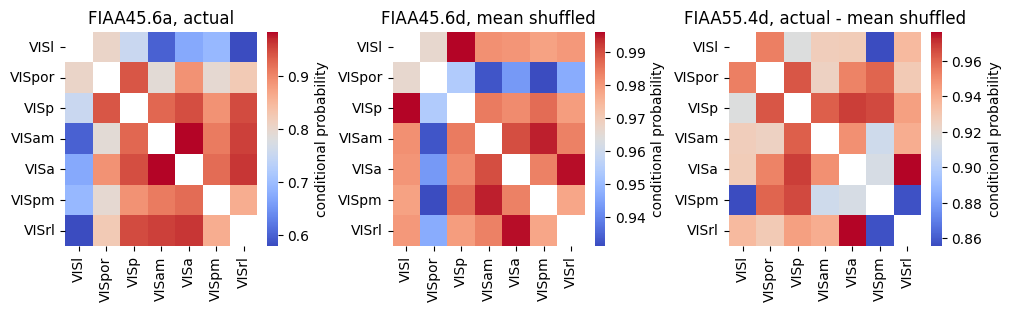

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3), constrained_layout = True)
for i, mouse in enumerate(mice):
    cosine_comp = get_cosine_sim_of_probs(cond_prob_dict[mouse], cols=cols)
    sb.heatmap(ax=axs[i], data=cosine_comp, cmap='coolwarm', xticklabels=True, yticklabels=True, cbar_kws={'label': 'conditional probability'}) 
    axs[i].set_title(f'{mouse}, {titles[i]}')


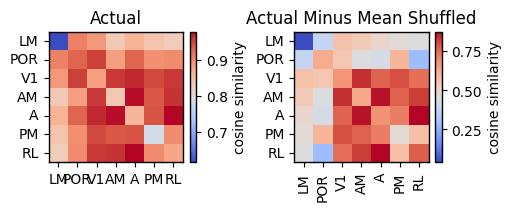

In [9]:
import itertools
fig, axs = plt.subplots(1, 2, figsize=(5, 2), constrained_layout = True)
which_ones = [cond_prob_dict, mouse_cond_prob_minus_shuff]
dict_to_look = mouse_cond_prob_minus_shuff
title = ['Actual', 'Actual Minus Mean Shuffled']
cosine_dict = {}
for i, dict_to_look in enumerate(which_ones):
    for mouse in mice:
        cosine_dict[mouse] = get_cosine_sim_of_probs(matrix=dict_to_look[mouse], cols = cols)
    #now for every value, get the cosine sim to itself
    to_itself_cosine = {}
    for area in cols:
        area_list = []
        for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
            neurons_1 = dict_to_look[mouse_a].loc[area]
            neurons_2 = dict_to_look[mouse_b].loc[area]
            neurons_1 =neurons_1.drop([area])
            neurons_2 =neurons_2.drop([area])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            area_list.append(cosine_similarity(bl, bl_2))
        to_itself_cosine[area] = np.mean(area_list)
    cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
    cosine_df= cosine_df.loc[cols][cols]
    for col in cols:
        cosine_df.loc[col, col] = to_itself_cosine[col]
    sb.heatmap(ax=axs[i], data=fpf.convert_matrix_names(cosine_df), cmap='coolwarm', xticklabels=True, yticklabels=True, cbar_kws={'label': 'cosine similarity'}) 
    axs[i].set_title(f'{title[i]}')
    axs[i].tick_params(axis='y', which='major', labelsize=10, rotation=0)
    axs[i].tick_params(axis='x', which='major', labelsize=10)
    for _, spine in axs[i].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
    cbar = axs[i].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

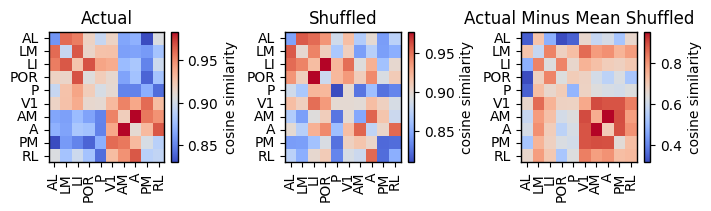

In [16]:
import itertools
fig, axs = plt.subplots(1, 3, figsize=(7, 2), constrained_layout = True)
which_ones = [cond_prob_dict, shuff_cond_prob_dict, mouse_cond_prob_minus_shuff]
dict_to_look = mouse_cond_prob_minus_shuff
title = ['Actual', 'Shuffled', 'Actual Minus Mean Shuffled']
cosine_dict = {}
for i, dict_to_look in enumerate(which_ones):
    for mouse in mice:
        cosine_dict[mouse] = get_cosine_sim_of_probs(matrix=dict_to_look[mouse], cols = cols)
    #now for every value, get the cosine sim to itself
    to_itself_cosine = {}
    for area in cols:
        area_list = []
        for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
            neurons_1 = dict_to_look[mouse_a].loc[area]
            neurons_2 = dict_to_look[mouse_b].loc[area]
            neurons_1 =neurons_1.drop([area])
            neurons_2 =neurons_2.drop([area])
            bl = np.array(neurons_1).reshape(1, -1)
            bl_2 = np.array(neurons_2).reshape(1, -1)
            area_list.append(cosine_similarity(bl, bl_2))
        to_itself_cosine[area] = np.mean(area_list)
    cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
    cosine_df= cosine_df.loc[cols][cols]
    for col in cols:
        cosine_df.loc[col, col] = to_itself_cosine[col]
    sb.heatmap(ax=axs[i], data=fpf.convert_matrix_names(cosine_df), cmap='coolwarm', xticklabels=True, yticklabels=True, cbar_kws={'label': 'cosine similarity'}) 
    axs[i].set_title(f'{title[i]}')
    axs[i].tick_params(axis='y', which='major', labelsize=10, rotation=0)
    axs[i].tick_params(axis='x', which='major', labelsize=10)
    for _, spine in axs[i].spines.items():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1)
    cbar = axs[i].collections[0].colorbar
    cbar.outline.set_visible(True)
    cbar.outline.set_edgecolor('black')
    cbar.outline.set_linewidth(1)

<AxesSubplot:>

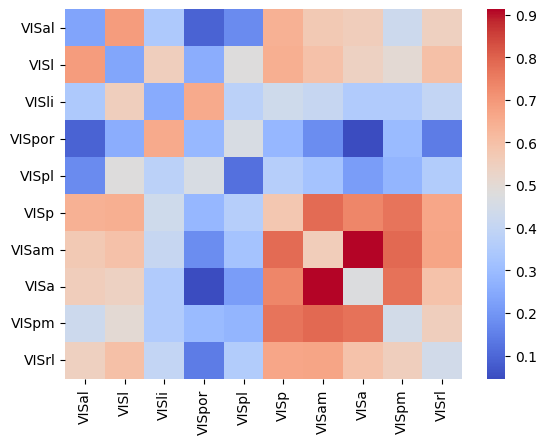

In [134]:
sb.heatmap(cosine_df, cmap='coolwarm')

In [132]:
def get_spearman_corr(matrix, cols):
    spearman_matrix = pd.DataFrame(data=np.zeros((len(cols), len(cols))), columns= cols, index=cols)
    for col in cols:
        for col_2 in cols:
            neurons_1 = matrix.loc[col]
            neurons_2 = matrix.loc[col_2]
            neurons_1 =neurons_1.drop([col, col_2])
            neurons_2 =neurons_2.drop([col, col_2])
            spearman_corr = neurons_1.corr(neurons_2, method='spearman')
            spearman_matrix.loc[col, col_2] = spearman_corr
            spearman_matrix.loc[col_2, col] = spearman_corr
    np.fill_diagonal(spearman_matrix.values, np.nan)
    return spearman_matrix

In [133]:
import itertools
dict_to_look = mouse_cond_prob_minus_shuff
cosine_dict = {}
for mouse in mice:
    cosine_dict[mouse] = get_spearman_corr(matrix=dict_to_look[mouse], cols = cols)
#now for every value, get the cosine sim to itself
to_itself_cosine = {}
for area in cols:
    area_list = []
    for mouse_a, mouse_b in list(itertools.combinations(mice, 2)):
        neurons_1 = dict_to_look[mouse_a].loc[area]
        neurons_2 = dict_to_look[mouse_b].loc[area]
        neurons_1 =neurons_1.drop([area])
        neurons_2 =neurons_2.drop([area])
        area_list.append(neurons_1.corr(neurons_2, method='spearman'))
    to_itself_cosine[area] = np.mean(area_list)
cosine_df = pd.concat(cosine_dict.values()).groupby(level=0).mean()
cosine_df= cosine_df.loc[cols][cols]
for col in cols:
    cosine_df.loc[col, col] = to_itself_cosine[col]

In [114]:
area_list

[0.7052137601008073, 0.17391304347826086, 0.44378553368642265]

In [115]:
area

'VISrl'

<AxesSubplot:>

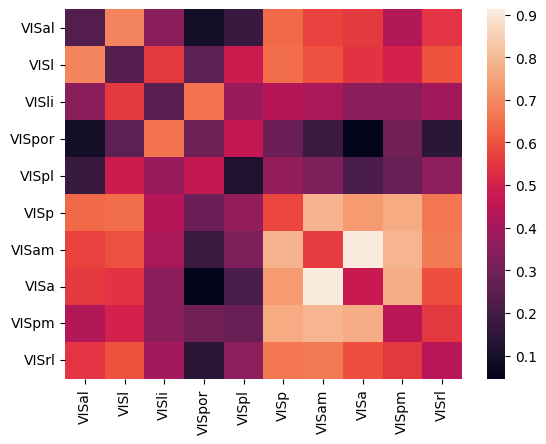

In [117]:
sb.heatmap(cosine_df)

In [26]:
mouse_cond_prob_minus_shuff[mouse].drop(columns=['VISal'])

,VISl,VISli,VISpor,VISpl,VISp,VISam,VISa,VISpm,VISrl,MOs,...,ACAv,SSp,PERI,AUDv,RSPd,AUDpo,MOp,SSs,ECT,RSPagl
VISal,0.008801,0.041662,0.205697,-0.000330,0.111782,0.198513,0.179717,0.119847,0.098340,0.045586,...,0.026183,0.181257,-0.002264,-0.056335,0.031658,0.251421,0.052048,0.160238,-0.280457,0.095520
VISl,NaN,0.076759,0.208686,0.004605,0.036569,0.128913,0.038404,0.105321,0.065695,0.046568,...,0.106593,0.080932,-0.025292,-0.091016,-0.023823,0.281183,0.085204,0.069626,-0.205750,0.104812
VISli,0.057385,NaN,0.131506,-0.004504,0.114077,0.101208,0.154354,0.083028,0.104975,0.029976,...,0.055606,0.066382,0.032542,-0.065113,0.079578,0.307559,0.028580,0.130345,-0.162158,0.117126
VISpor,0.033927,0.029740,NaN,0.015642,0.103591,0.086190,0.073977,0.094221,0.042811,0.037021,...,0.029048,0.027349,0.094444,0.029409,0.044201,0.236542,0.035635,-0.047851,-0.054161,0.119216
VISpl,0.046526,0.034201,0.246371,NaN,0.071279,-0.071506,-0.121893,0.045205,0.032281,0.026248,...,0.086650,0.020434,-0.005127,-0.151438,0.075997,0.221489,0.024961,0.109284,0.054364,0.173542
VISp,0.025611,0.049559,0.304125,0.010286,NaN,0.197296,0.192570,0.067285,0.089462,0.026417,...,0.015114,0.121071,0.023135,-0.037193,0.097425,0.321461,0.053578,0.052394,-0.302590,0.177457
VISam,0.039431,0.037077,0.196790,-0.008296,0.163509,NaN,0.059482,0.131565,0.214581,0.055813,...,0.021836,0.262181,0.012056,0.031150,0.038594,0.357034,0.042715,0.109425,-0.233764,0.081841
VISa,0.009996,0.037103,0.099670,-0.008277,0.103718,0.068388,NaN,0.085077,0.099378,0.066126,...,0.015925,0.104855,-0.002644,0.025268,0.063062,0.287900,0.086817,0.141700,-0.255812,0.083675
VISpm,0.046119,0.043705,0.334931,0.008102,0.126184,0.191544,0.189767,NaN,0.063439,0.073910,...,0.019362,0.049065,0.058418,-0.077666,0.092584,0.328475,0.088892,-0.015236,-0.219560,0.094493
VISrl,0.016677,0.033900,0.050192,0.002851,0.064243,0.195412,0.019274,0.034300,NaN,0.082089,...,0.030889,0.006698,-0.005510,0.037499,0.042760,0.266039,0.113971,0.231427,-0.234396,0.055905


In [23]:
import itertools
for a, b in list(itertools.combinations(mice, 2)):
    print(f'{a} then {b}')

FIAA45.6a then FIAA45.6d
FIAA45.6a then FIAA55.4d
FIAA45.6d then FIAA55.4d


<AxesSubplot:>

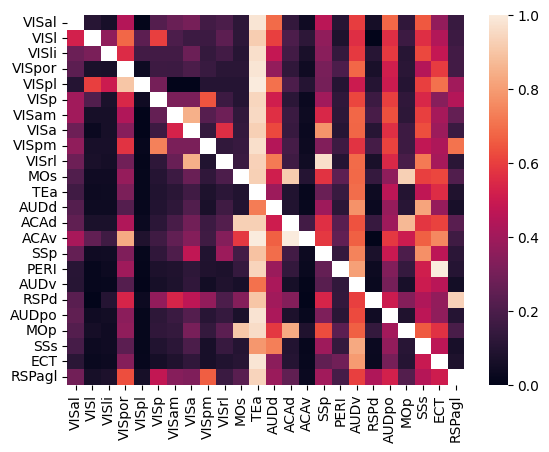

In [9]:
sb.heatmap(cond_prob_dict[mouse])

<AxesSubplot:>

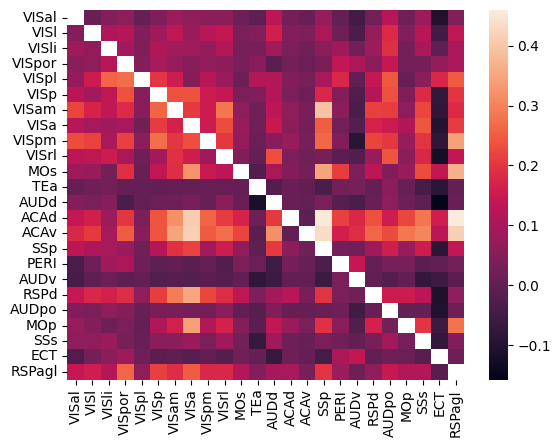

In [16]:
sub = pd.concat(mouse_cond_prob_minus_shuff.values()).groupby(level=0).mean()
sub= sub.loc[cols_reordered][cols_reordered]
sb.heatmap(sub)

In [12]:
mean_df = pd.DataFrame()
for row in cols_reordered:
    for col in cols_reordered:
        col_array = []
        for mouse in mice:
            col_array.append(cond_prob_dict[mouse].loc[row, col])
        mean_df.loc[row, col] = np.mean(col_array)
        

<AxesSubplot:>

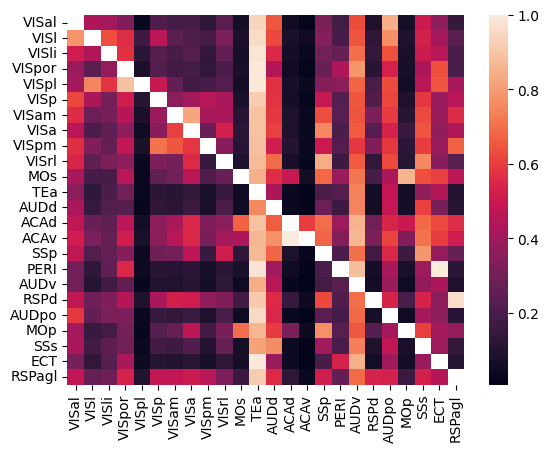

In [13]:
sb.heatmap(mean_df)

<AxesSubplot:>

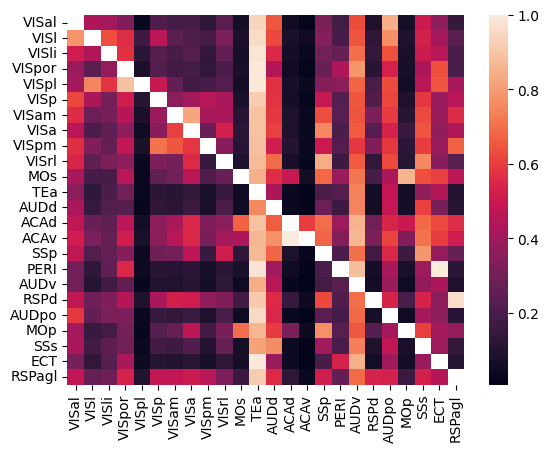

In [10]:
new_mena = pd.concat(cond_prob_dict.values()).groupby(level=0).mean()
new_mena= new_mena.loc[cols_reordered][cols_reordered]
sb.heatmap(new_mena)